# DMML-07

Linear Models Revisited: Ridge and LAD Regression; `statsmodels`
package.

David Apagyi  
2025-11-06

**Web page:** <a href="https://apagyidavid.web.elte.hu/2025-2026-1/dmml"
target="_blank">apagyidavid.web.elte.hu/2025-2026-1/dmml</a>

<a target="_blank" href="https://colab.research.google.com/github/dapagyi/dmml-web/blob/notebooks/dmml-07.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Models Revisited

We have already seen the OLS, i.e., ordinary least squares linear
regression model in the exercise
<span class="badge text-bg-warning me-1">HW/2</span><a href="./dmml-hw-02" target="_blank">Linear
regression.</a>

Today, we will consider some extensions and alternatives of the OLS
linear regression model, primarily focusing on regularized[1] linear
regression models.

> **Reminder: Importance of Regularization**
>
> Regularization can help in several issues, for example:
>
> -   To convert an *ill-posed* problem to a *well-posed* problem.
> -   To make an *ill-conditioned* approach better *conditioned.*
> -   To reduce *over-fitting* and thus to help the *generalization.*
> -   To force the *sparsity* of the solution.
> -   Or in general to control *shape* and *smoothness.*

The OLS solution minimizes the residual sum of squares (RSS): $$
|| \varepsilon(\theta) |_2^2 = || y - \Phi \theta ||_2^2,
$$ where $y$ is the vector of observed values, $\Phi$ is the design
matrix (or regression matrix) calculated from the input features.
($\Phi \in \mathbb{R}^{n \times d}$, where $n$ is the number of samples
and $d$ is the number of basis functions/features.)

Some other important linear models are the following (the lambdas are
regularization parameters):

-   **Ridge Regression** (or Tikhonov regularization): $$
    || y - \Phi \theta ||_2^2 + \lambda || \theta ||_2^2,
    $$
-   **LASSO Regression:** $$
    || y - \Phi \theta ||_2^2 + \lambda || \theta ||_1,
    $$
-   **Elastic Net Regression:** $$
    || y - \Phi \theta ||_2^2 + \lambda_1 || \theta ||_1 + \lambda_2 || \theta ||_2^2,
    $$
-   **Least Absolute Deviations (LAD) Regression:** $$
    || y - \Phi \theta ||_1.
    $$

**Question:** Consider the loss functions of the ridge regression and
the lasso regression. What “properties” do the $L^2$ and $L^1$
regularization terms impose on the solution?

## Ridge Regression

It is straightforward to see that the ridge regression can be solved
based on the OLS solution. Let $$
\Phi' = \begin{bmatrix}
\Phi \\
\sqrt{\lambda} I
\end{bmatrix}
$$ and $$
y' = \begin{bmatrix}
y \\
0
\end{bmatrix},
$$ then the Ridge regression solution is equivalent to the OLS solution
with $\Phi'$ and $y'$: $$
|| y' - \Phi' \theta ||_2^2 = || y - \Phi \theta ||_2^2 + \lambda || \theta ||_2^2,
$$ since $$
\begin{align*}
y' - \Phi' \theta &= \begin{bmatrix}
y \\
0
\end{bmatrix} - \begin{bmatrix}
\Phi \\
\sqrt{\lambda} I
\end{bmatrix} \theta = \\ &= \begin{bmatrix}
y - \Phi \theta \\
- \sqrt{\lambda} \theta
\end{bmatrix}.
\end{align*}
$$

Thus, the ridge regression solution is $$
\begin{align*}
\hat{\theta} &= (\Phi'^T \Phi')^{-1} \Phi'^T y' = \\ &= (\Phi^T \Phi + \lambda I)^{-1} \Phi^T y.
\end{align*}
$$

Let’s implement ridge regression based on the solution of HW/2.

[1] The *Importance of Regularization* section is quoted from the
lecture notes.

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg.lapack import dtrtri
from sklearn.metrics import mean_squared_error, r2_score

rng = np.random.default_rng()

This was our solution for the OLS in HW/2 using polynomial basis
functions (some details have been altered, e.g., the approximated
function is slightly different):

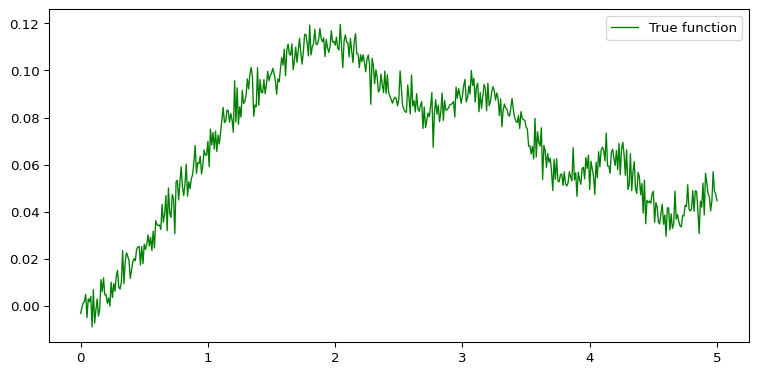

In [2]:
def f(x):
    return (np.exp(1 - x) * x**2 + 0.3 * np.sin((x / 1.5) ** 2) ** 2) / (3 * np.log(np.sin(0.75 * x) + 200))


x = np.arange(0, 5.01, 0.01)
fx = f(x)
y = fx + 5e-3 * rng.standard_normal(x.size)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y, color="green", lw=1, label="True function")
ax.legend()
plt.tight_layout()
plt.show()

In [3]:
class PhiCalculator:
    def __init__(self, basis_functions):
        self.basis_functions = basis_functions

    def __call__(self, x):
        return np.column_stack([f(np.asarray(x)) for f in self.basis_functions])


def f_i(x, i, d):
    return x ** (i - 1)


d = 11
basis_functions = [partial(f_i, i=i + 1, d=d) for i in range(d)]
Phi = PhiCalculator(basis_functions)(x)

print(f"Shape of Phi (should be n×d): {Phi.shape}")

[Q, R] = np.linalg.qr(Phi)
R_inv, _ = dtrtri(R, lower=0)
theta = (R_inv @ Q.T) @ y
preds = Phi @ theta

Shape of Phi (should be n×d): (501, 11)

array([ 4.13264244e-03, -1.36532939e-01,  1.04123470e+00, -2.46732712e+00,
        3.21195264e+00, -2.45512769e+00,  1.14264792e+00, -3.27838059e-01,
        5.66390325e-02, -5.40436194e-03,  2.18846663e-04])

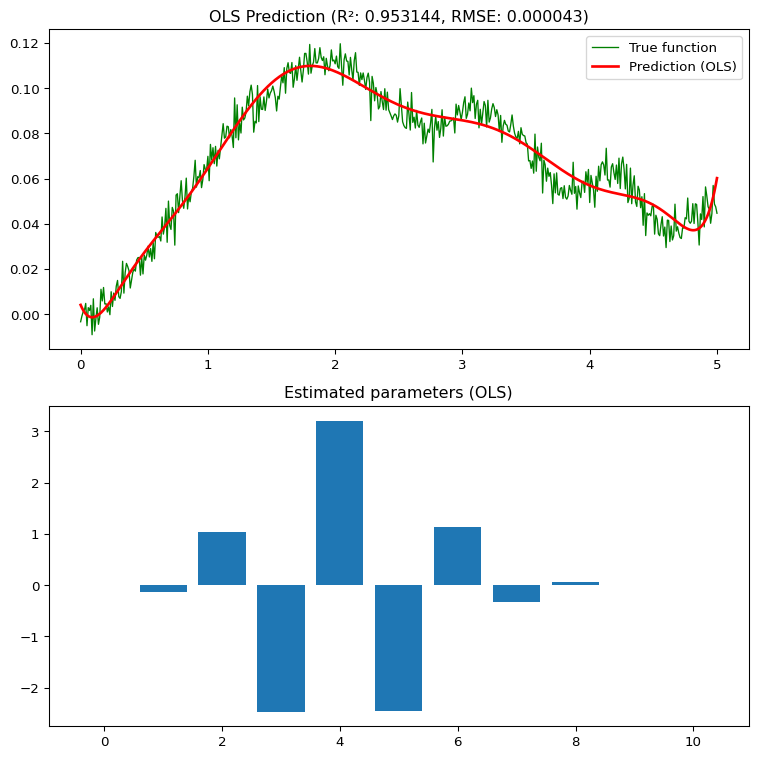

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x, y, color="green", lw=1, label="True function")
ax1.plot(x, preds, color="red", lw=2, label="Prediction (OLS)")
ax1.legend()
ax1.set_title(f"OLS Prediction (R²: {r2_score(y, preds):.6f}, RMSE: {mean_squared_error(y, preds):.6f})")

display(theta)
ax2.bar(x=range(theta.size), height=theta)
ax2.set_title("Estimated parameters (OLS)")

plt.tight_layout()
plt.show()

**Exercise:** Based on the OLS solution above, implement the
`RidgeRegression` class below by completing the `fit` and `predict`
methods.

In [5]:
class RidgeRegression:
    def __init__(self, lambda_=0.01, d=None, basis_functions=None):
        self.lambda_ = lambda_

        if not basis_functions:
            if not d:
                d = 11
            basis_functions = [partial(f_i, i=i + 1, d=d) for i in range(d)]
        self.basis_functions = basis_functions

    def fit(self, X, y):
        pass
        # TODO

    def predict(self, X):
        pass
        # TODO

Some examples with different values of the regularization parameter
$\lambda$:

In [7]:
def ridge_demo(lambda_: float, plot=True) -> tuple[np.ndarray, float, float]:
    ridge_model = RidgeRegression(lambda_=lambda_)
    ridge_model.fit(x, y)
    ridge_preds = ridge_model.predict(x)

    r2 = r2_score(y, ridge_preds)
    rmse = mean_squared_error(y, ridge_preds)

    if plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
        ax1.plot(x, y, color="green", lw=1, label="True function")
        ax1.plot(x, ridge_preds, color="blue", lw=2, label="Prediction (Ridge)")
        ax1.legend()
        ax1.set_title(f"Ridge Regression ($\\lambda ={lambda_}$): R²: {r2:.4f}, RMSE: {rmse:.6f}")

        ax2.bar(x=[f"$\\theta_{i}$" for i in range(ridge_model.theta_.size)], height=ridge_model.theta_)
        ax2.set_title("Estimated parameters (Ridge)")

        plt.tight_layout()
        plt.show()

    return ridge_model.theta_, r2, rmse


ridge_demo(lambda_=1e-3)
pass

Let’s see what happens with a larger regularization parameter:

In [8]:
ridge_demo(lambda_=1e-1)
pass

In [9]:
lambdas = np.logspace(-7, 1, 100)
thetas = np.zeros((lambdas.size, 11))
r2s = np.zeros(lambdas.size)
rmses = np.zeros(lambdas.size)
for i, lambda_ in enumerate(lambdas):
    theta_, r2, rmse = ridge_demo(lambda_, plot=False)
    thetas[i, :] = theta_
    r2s[i] = r2
    rmses[i] = rmse

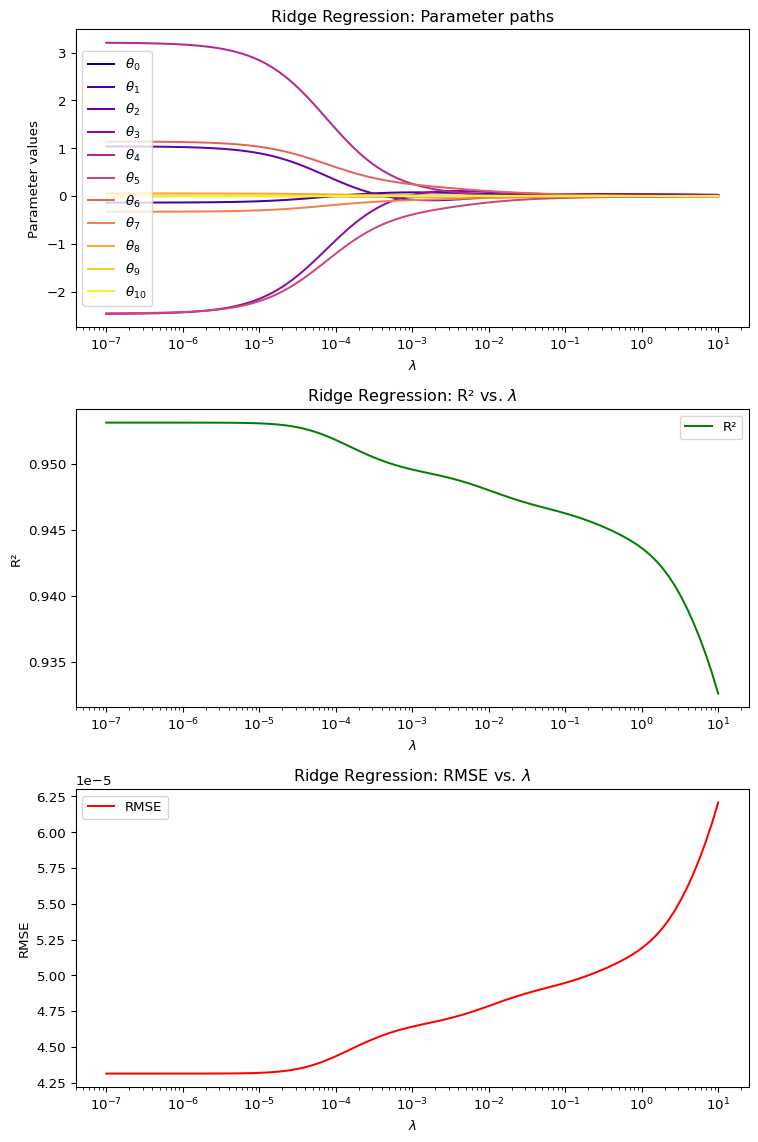

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
ax = axs[0]
colors = plt.get_cmap("plasma", thetas.shape[1])
for i in range(thetas.shape[1]):
    ax.plot(lambdas, thetas[:, i], label=f"$\\theta_{{{i}}}$", color=colors(i))
ax.set_xscale("log")
ax.set_title("Ridge Regression: Parameter paths")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("Parameter values")
ax.legend()

ax = axs[1]
ax.plot(lambdas, r2s, label="R²", color="green")
ax.set_xscale("log")
ax.set_title("Ridge Regression: R² vs. $\\lambda$")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("R²")
ax.legend()

ax = axs[2]
ax.plot(lambdas, rmses, label="RMSE", color="red")
ax.set_xscale("log")
ax.set_title("Ridge Regression: RMSE vs. $\\lambda$")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("RMSE")
ax.legend()

plt.tight_layout()
plt.show()

## LAD Regression

Least Absolute Deviations (LAD) (or least absolute errors (LAE), least
absolute residuals (LAR), least absolute values (LAV)[1]) regression
minimizes the sum of absolute deviations:

$$
|| y - \Phi \theta ||_1 = \sum_{i=1}^{n} |y_i - \phi_i^T \theta|.
$$

LAD regression can be formulated as a linear programming problem. The
objective is to minimize the sum of absolute deviations, which can be
expressed as:

$$
\begin{align*}
\text{minimize} \quad & u^T \mathbf{1} \\
\text{subject to} \quad & y - \Phi \theta \leq u \\
& - (y - \Phi \theta) \leq u
\end{align*}
$$

There are several LP (MILP) solvers available in Python, e.g.,
Python-Mip, `scipy.optimize.linprog`, PuLP, CVXPY, OR-Tools.

**Exercise:** Implement the `LADRegression` class below using your
favorite LP solver, and test it on a small example dataset.

[1] See
<a href="https://en.wikipedia.org/wiki/Least_absolute_deviations"
target="_blank">Wikipedia: Least absolute deviations.</a>

In [11]:
class LADRegression:
    def __init__(self):
        pass
        # TODO

    def fit(self, X, y):
        pass
        # TODO

    def predict(self, X):
        pass
        # TODO

# The `statsmodels` package

The `statsmodels` package provides an R-like interface for statistical
modeling in Python. It includes several models, tests, and data
exploration tools.

Let’s see how to perform (OLS) linear regression using `statsmodels`:

In [12]:
import statsmodels.api as sm


X_sm = sm.add_constant(Phi)
model = sm.OLS(y, X_sm)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     996.8
Date:                Thu, 27 Nov 2025   Prob (F-statistic):          2.81e-318
Time:                        09:52:57   Log-Likelihood:                 1806.9
No. Observations:                 501   AIC:                            -3592.
Df Residuals:                     490   BIC:                            -3546.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.003      1.343      0.1

For more details, check the <a
href="https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html"
target="_blank">documentation.</a>